# Импорт

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import random
import seaborn as sb
from collections import defaultdict
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from copy import deepcopy
from torchsummary import summary

In [ ]:
# fix random_seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
print(torch.version)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

<module 'torch.version' from '/usr/local/lib/python3.10/dist-packages/torch/version.py'>
True
1
0
Tesla T4


In [ ]:
!nvidia-smi

Mon Jun 12 18:12:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
x_data_np = np.load('drive/MyDrive/Чирич/all_movies.npy')
y_data_np = np.load('drive/MyDrive/Чирич/all_piv.npy')
x_data_np = np.float32(x_data_np)
y_data_np = np.float32(y_data_np)
print(f'X shape {x_data_np.shape}\n Y shape {y_data_np.shape}')

X shape (27, 136, 314, 316)
 Y shape (27, 2, 27, 27)


# DataLoader

In [ ]:
x_data = torch.from_numpy(x_data_np)
y_data = torch.from_numpy(y_data_np)

idx = torch.randperm(x_data.shape[0])
idx_train = idx[:21]
idx_test = idx[-6:]
print(idx_train)
print(idx_test)

x_train = x_data[idx_train]
x_test = x_data[idx_test]

y_train = y_data[idx_train]
y_test = y_data[idx_test]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

tensor([ 6, 22,  3, 25, 20, 26,  2, 11, 13,  4, 19, 17,  7, 12, 23, 10,  9,  1,
        21, 18, 15])
tensor([14,  0,  5, 16, 24,  8])
torch.Size([21, 136, 314, 316])
torch.Size([6, 136, 314, 316])
torch.Size([21, 2, 27, 27])
torch.Size([6, 2, 27, 27])


In [ ]:
mean = x_train.mean()
std = x_train.std()
print(mean, std)
mean = mean * 136
std = std * 136

tensor(0.2744) tensor(0.2150)


In [ ]:
class CustomTensorDatasetTrain(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, mov, img):
        self.mov = mov
        self.img = img
        self.norm = torchvision.transforms.Normalize(mean, std)

        #self.PIL = torchvision.transforms.ToPILImage()

    def __getitem__(self, index):
        #self.mov[index] = self.mov[index][:, :80]
        #self.mov[index] = self.mov[index][:, None, :, :, :]
        if random.random() > 0.5:
            self.mov[index] = TF.hflip(self.mov[index])
            self.img[index] = TF.hflip(self.img[index])

        if random.random() > 0.5:
            self.mov[index] = TF.vflip(self.mov[index])
            self.img[index] = TF.vflip(self.img[index])

        self.mov[index] = self.norm(self.mov[index])

        return self.mov[index], self.img[index]

    def __len__(self):
        return self.mov.shape[0]


class CustomTensorDatasetTest(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, mov, img):
        self.mov = mov
        self.img = img
        self.norm = torchvision.transforms.Normalize(mean, std)

        #self.PIL = torchvision.transforms.ToPILImage()

    def __getitem__(self, index):
        #self.mov[index] = self.mov[index][:, :80]
        #self.mov[index] = self.mov[index][:, None, :, :, :]
        self.mov[index] = self.norm(self.mov[index])

        return self.mov[index], self.img[index]

    def __len__(self):
        return self.mov.shape[0]

# ResNet18

In [ ]:
batch_size = 8
train_data = CustomTensorDatasetTrain(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

batch_size_test = 6
test_data = CustomTensorDatasetTest(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

In [ ]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # (1, 512, 1, 1).  поменять
        resnet = models.resnet18(pretrained=False)
        resnet.conv1 = nn.Conv2d(136, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        enc = list(resnet.children())[:-1]

        self.encoder = nn.Sequential(*(list(enc)))

        self.decoder = nn.Sequential(
                #PrintLayer(),

                nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1),
                nn.Upsample(scale_factor=2, mode='bilinear'),
                nn.ReLU(),
                #PrintLayer(),

                nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1),
                nn.Upsample(scale_factor=2, mode='bilinear'),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                #PrintLayer(),

                nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1),
                nn.Upsample(scale_factor=2, mode='bilinear'),
                nn.ReLU(),
                #PrintLayer(),

                nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1),
                nn.Upsample(scale_factor=2, mode='bilinear'),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                #PrintLayer(),

                nn.ConvTranspose2d(32, 16, 3, stride=2, padding=3),
                nn.Upsample(size=(27, 27), mode='bilinear'),
                nn.ReLU(),
                #PrintLayer(),

                nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(),
                #PrintLayer(),

                nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                #PrintLayer(),

                nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1)
        )
        #self.dropout1 = nn.Dropout(p=0.5)




    def forward(self, x):

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

# Обучение

In [ ]:
class ProgressPlotter:

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="best")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(10 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)


class BaseTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader,
    ):
        self.model = model
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
        self.scheduler = None
        self.num_epochs = 10
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.best_model = None
        self.best_loss = None
        #self.set_score_function(nn.MSELoss(), "accuracy")
        self.pp = ProgressPlotter(title="baseline", groups=["loss"])

   # def set_score_function(self, score_function, title="MSE"):
    #    self.score_function = score_function
     #   self.quality_metric = title

    def train_epoch(self):

        self.model.train()
        loss_hist = []
        for images, labels in self.train_dataloader:
            self.optimizer.zero_grad()
            preds = self.model(images.to(self.device))
            loss = self.criterion(preds, labels.to(self.device))
            loss.backward()
            loss_hist.append(loss.detach().cpu())
            self.optimizer.step()
        return torch.stack(loss_hist).mean().item()

    def val_epoch(self):
        loss_hist = []
        self.model.eval()
        with torch.no_grad():
            for images, labels in self.test_dataloader:
                preds = self.model(images.to(self.device))
                loss = self.criterion(preds, labels.to(self.device))
                loss_hist.append(loss.detach().cpu())
        return torch.stack(loss_hist).mean()

    def fit(self, verbose=True, val_only = False):
        self.model.to(self.device)
        best_loss_on_val = np.inf
        i = 0
        for epoch in tqdm(range(self.num_epochs)):
            loss_on_train = self.train_epoch()
            loss_on_val = self.val_epoch()

            if self.scheduler is not None:
                self.scheduler.step()

            if best_loss_on_val > loss_on_val:
                print("Best model updated")
                best_metric_on_val = loss_on_val
                self.best_loss = best_metric_on_val
                self.save_best_model()

            if i > 0:
                self.pp.add_scalar(group="loss", value=loss_on_train, tag="train")
                self.pp.add_scalar(group="loss", value=loss_on_val, tag="val")
                if verbose:
                    self.pp.display()
            i += 1

            #if verbose:
             #   self.pp.display()

    #def validate(self, on_train=False, using_best_model=False, **kwargs):

     #   dl = self.train_dataloader if on_train else self.test_dataloader
      #  model = self.best_model if using_best_model else self.model

       # y_pred, y_true = self.get_predictions(model, dl)
        #return self.score_function(y_pred, y_true)#, **kwargs)

    def give_best_model(self, on_train=False, using_best_model=False, **kwargs):

        dl = self.train_dataloader if on_train else self.test_dataloader
        model = self.best_model if using_best_model else self.model
        return model

    def give_best_loss(self):

        return self.best_loss

    def get_predictions(self, model, dl):
        y_pred = torch.tensor([])
        y_true = torch.tensor([])

        with torch.no_grad():
            for i, data in enumerate(dl):
                img, label = data
                outputs = model(img.to(self.device))
                _, predicted = torch.max(outputs.data, 1)
                y_pred = torch.cat((y_pred, predicted.cpu().detach()))
                y_true = torch.cat((y_true, label))
        return y_pred, y_true

    def save_best_model(
        self,
    ):
        model_copy = deepcopy(self.model)
        self.best_model = model_copy

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

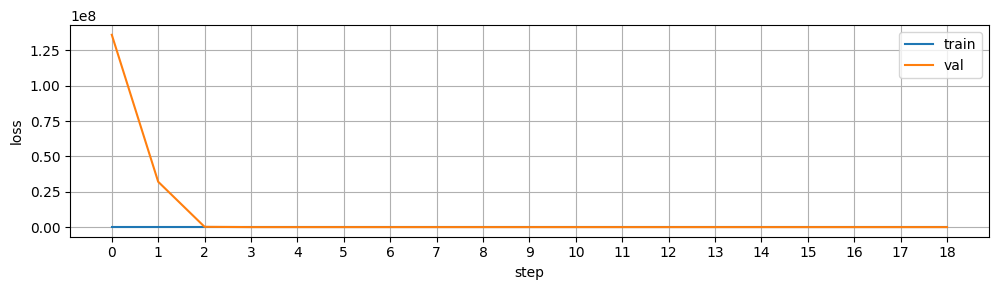

In [ ]:
trainer = BaseTrainer(
    model=ConvNet(),
    train_dataloader=train_loader ,
    test_dataloader=test_loader ,
)

trainer.num_epochs = 20
trainer.scheduler = torch.optim.lr_scheduler.MultiStepLR(trainer.optimizer, milestones=[4, 8, 12, 16], gamma=0.1)
trainer.criterion = nn.MSELoss()
trainer.fit()

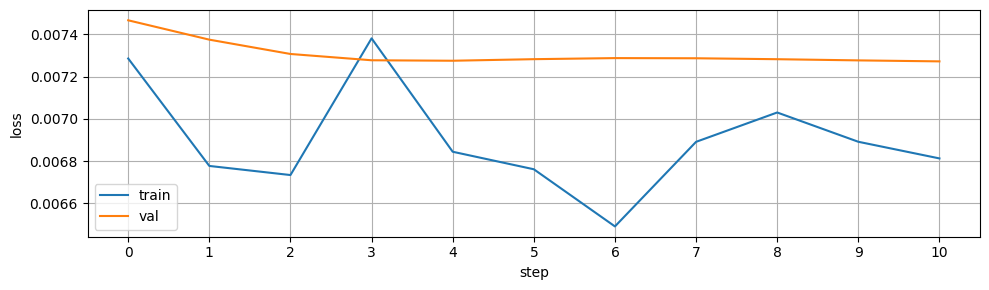

In [ ]:
trainer = BaseTrainer(
    model=ConvNet(),
    train_dataloader=train_loader ,
    test_dataloader=test_loader ,
)

trainer.num_epochs = 20
trainer.fit()

# ResNet3D

In [ ]:
# torch summery сравнить две сети и их размеры

In [ ]:
batch_size = 1
train_data = CustomTensorDatasetTrain(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

batch_size_test = 1
test_data = CustomTensorDatasetTest(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

In [ ]:
class ConvNet3D(nn.Module):
    def __init__(self):
        super(ConvNet3D, self).__init__()

        resnet_3d = models.video.r3d_18(pretrained=False)
        resnet_3d.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.encoder = torch.nn.Sequential(*(list(resnet_3d.children())[:-1]))

        self.decoder = nn.Sequential(
                #PrintLayer(),

                nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1),
                nn.Upsample(scale_factor=2, mode='bicubic'), #попробовать 'bicubic' and 'trilinear
                nn.ReLU(True),
                #PrintLayer(),

                nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1),
                nn.Upsample(scale_factor=2, mode='bicubic'),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                #PrintLayer(),

                nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1),
                nn.Upsample(scale_factor=2, mode='bicubic'),
                nn.ReLU(True),
                #PrintLayer(),

                nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1),
                nn.Upsample(scale_factor=2, mode='bicubic'),
                nn.BatchNorm2d(32),
                nn.ReLU(True),
                #PrintLayer(),

                nn.ConvTranspose2d(32, 16, 3, stride=2, padding=3),
                nn.Upsample(size=(27, 27), mode='bicubic'),
                nn.ReLU(True),
                #PrintLayer(),

                nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                #PrintLayer(),

                nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1),
                nn.ReLU(True),
                #PrintLayer(),

                nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1)
        )
        #self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x[:, :80] #
        x = x[:, None, :, :, :] # перенести в даталоадер
        encoded = self.encoder(x)
        encoded = encoded[:, :, 0]
        decoded = self.decoder(encoded)

        return decoded

# Обучение

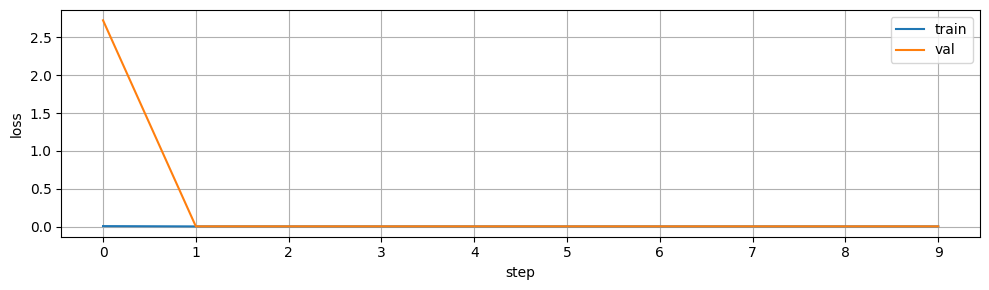

In [ ]:
trainer_3d = BaseTrainer(
    model=ConvNet3D(),
    train_dataloader=train_loader ,
    test_dataloader=test_loader ,
)

#trainer.optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
trainer_3d.scheduler = torch.optim.lr_scheduler.MultiStepLR(trainer_3d.optimizer, milestones=[4,8], gamma=0.1)
#trainer.criterion = nn.MSELoss()
trainer_3d.num_epochs = 10
trainer_3d.fit()

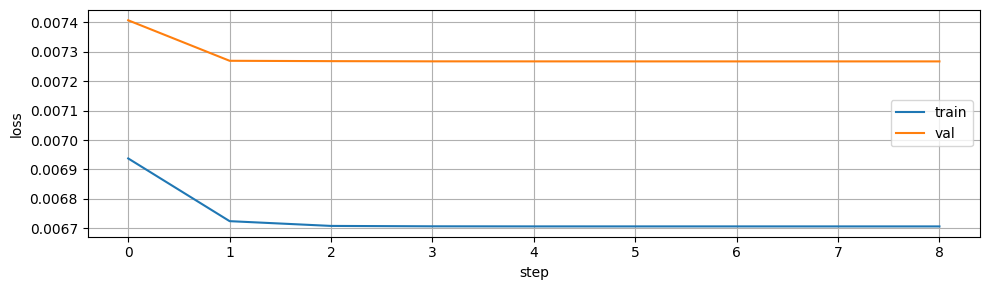

In [ ]:
trainer_3d = BaseTrainer(
    model=ConvNet3D(),
    train_dataloader=train_loader ,
    test_dataloader=test_loader ,
)

trainer_3d.scheduler = torch.optim.lr_scheduler.MultiStepLR(trainer_3d.optimizer, milestones=[4,8], gamma=0.1)
trainer_3d.num_epochs = 10
trainer_3d.fit()

# Проверка

ResNet18

In [ ]:
best_model = trainer.give_best_model()

In [ ]:
n = 0
for _, batch in enumerate(test_loader, 0):
    mov, img = batch
    mov, img = mov.to(device), img.to(device)
    if n > 3:
        break

<Axes: >

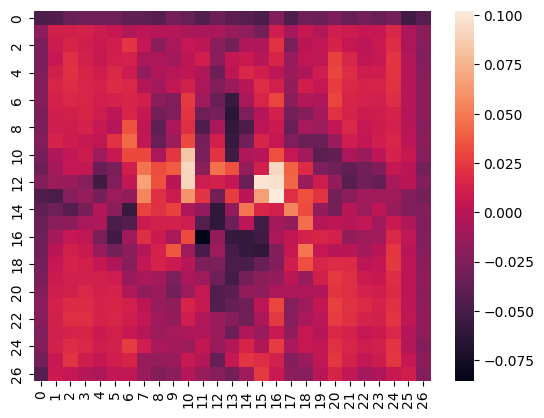

In [ ]:
best_model.eval()
pred_img = best_model(mov)
x = pred_img[1, 0].cpu().detach().numpy()
sb.heatmap(x)

<Axes: >

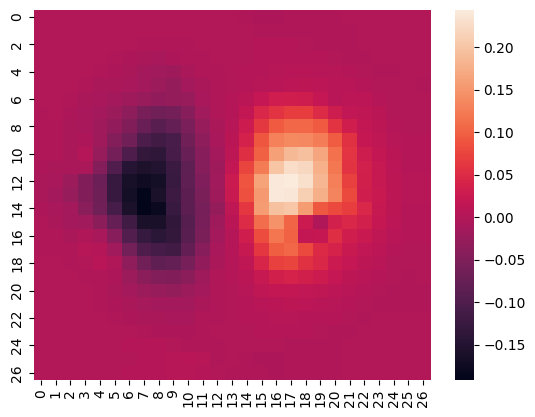

In [ ]:
test_img = img[0, 0].cpu().detach().numpy()
sb.heatmap(test_img)

ResNet3D

In [ ]:
best_model_3d = trainer_3d.give_best_model()

In [ ]:
n = 0
for _, batch in enumerate(test_loader, 0):
    mov, img = batch
    mov, img = mov.to(device), img.to(device)
    if n > 5:
        break

<Axes: >

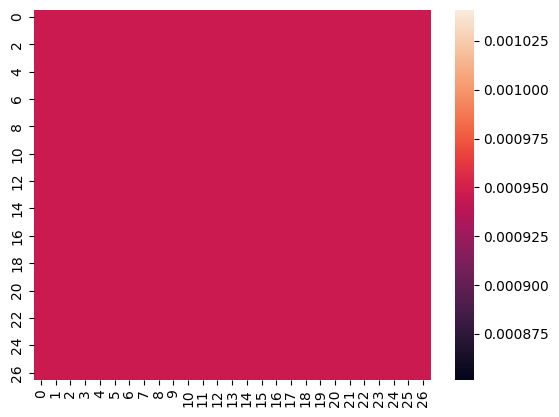

In [ ]:
best_model_3d.eval()
pred_img = best_model_3d(mov)
x = pred_img[0, 0].cpu().detach().numpy()
sb.heatmap(x)

<Axes: >

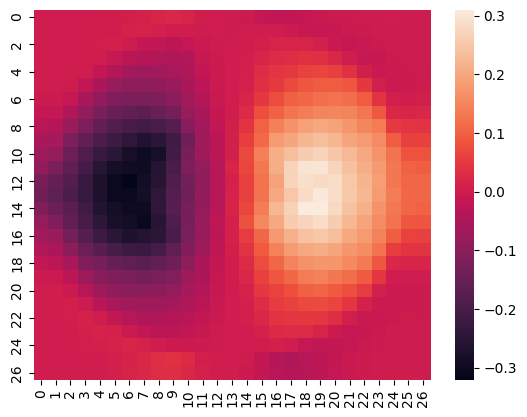

In [ ]:
test_img = img[0, 0].cpu().detach().numpy()
sb.heatmap(test_img)